<a href="https://colab.research.google.com/github/KeletsoM/JHB_rm_2_unsupervised/blob/side-branch/Rough_draft_Report_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

The purpose of this report is to contstruct a recommender system which will accurately predict how a user will rate a movie they have not yet seen based on historical preferences. The economic value in producing such a system has great commercial impact because it will mean users will enjoy the service which eliminates the process of having to search for your ideal movie to watch, creating brand loyality and also increased revenues as more movies being watched.

Because this is unsupervised learning, there is no target response in the data set and thus there are many predictors which will have to be used to identify the relevance of fit to the recommender algorithm. These include genre, rating, budget, director and release date to name a few. 

For this report, an investigation has to be conducted as to whether a content-based or collaborative filtering approach will be used and therefore, it will be prudent to test both methods and use the one which produces the most accurate results. 

# Data

"The data for the MovieLens dataset is maintained by the GroupLens research group in the Department of Computer Science and Engineering at the University of Minnesota. Additional movie content data was legally scraped from IMDB." https://www.kaggle.com/c/edsa-recommender-system-predict/data  It consists of:

*   genome_scores.csv - a score mapping the strength between movies and tag-related properties.
*   genome_tags.csv - user assigned tags for genome-related  scores
*   imdb_data.csv - Additional movie metadata scraped from IMDB using the links.csv file.
*   links.csv - File providing a mapping between a MovieLens ID and associated IMDB and TMDB IDs.
*   sample_submission.csv - Sample of the submission format for the hackathon.
*   tags.csv - User assigned for the movies within the dataset.
*   test.csv - The test split of the dataset. Contains user and movie IDs with no rating data.
*   train.csv - The training split of the dataset. Contains user and movie IDs with associated rating data.







# Importing the libraries

In [57]:
import pandas as pd

# Time converter
import datetime

# To do linear algebra
import numpy as np

# To create plots
import matplotlib.pyplot as plt # data visualization library
import seaborn as sns
sns.set_style('whitegrid')
from wordcloud import WordCloud, STOPWORDS #used to generate world cloud

# To create interactive plots
from plotly.offline import init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)
from dataprep.eda import *
#from plotly.subplots import make_subplots
import cufflinks as cf
import plotly.express as px

# To shift lists
from collections import deque

# To compute similarities between vectors
from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
import random

# To use recommender systems
import surprise as sp
from surprise.model_selection import cross_validate

# To stack sparse matrices
from scipy.sparse import vstack
from scipy import sparse
from scipy.sparse import csr_matrix

NumExpr defaulting to 8 threads.


# Importing the data 

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
movies = pd.read_csv('movies.csv')
tags = pd.read_csv('tags.csv')
links = pd.read_csv('links.csv')
imdb_data = pd.read_csv('imdb_data.csv')
genome_tags = pd.read_csv('genome_tags.csv')
genome_scores = pd.read_csv('genome_scores.csv')
imdb_data = pd.read_csv('imdb_data.csv')

# Data Preprocessing

## Perusing the data

* Entity relationship diagram

* This line represents a one-to-many relationship:  

* This line represents a one-to-one relationship:  

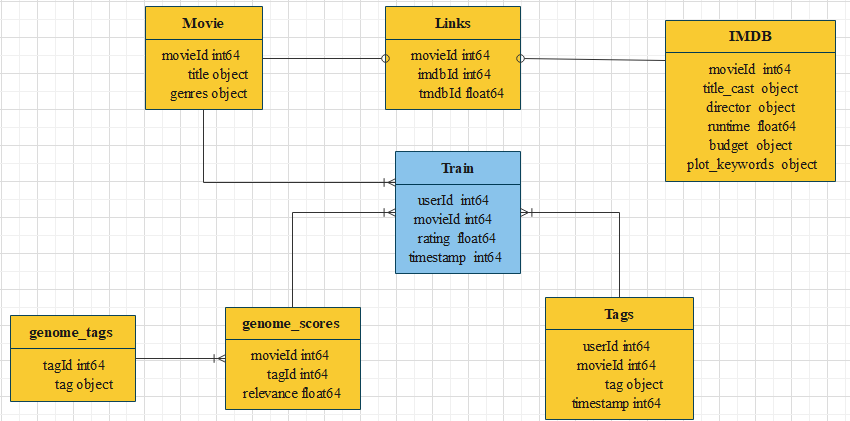

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000038 entries, 0 to 10000037
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 305.2 MB


In [5]:
train.describe()['rating']

count    1.000004e+07
mean     3.533395e+00
std      1.061124e+00
min      5.000000e-01
25%      3.000000e+00
50%      3.500000e+00
75%      4.000000e+00
max      5.000000e+00
Name: rating, dtype: float64

In [6]:
train['rating'].value_counts()

4.0    2652977
3.0    1959759
5.0    1445230
3.5    1270642
4.5     880516
2.0     656821
2.5     505578
1.0     311213
1.5     159731
0.5     157571
Name: rating, dtype: int64

In [7]:
# Converting the timestamp to a date 
train['date'] = train['timestamp'].apply(lambda d: 
                                         datetime.datetime.fromtimestamp(int(d))
                                         .strftime('%Y-%m-%d'))
train.drop('timestamp', axis=1, inplace=True)
train['date'] = pd.to_datetime(train['date'])
train.sort_values(by='date')

,userId,movieId,rating,date
5065562,2262,47,5.0,1995-01-09
9758432,109832,21,4.0,1996-01-29
1703133,102689,10,4.0,1996-01-29
2779110,102689,45,4.0,1996-01-29
7821709,109832,36,5.0,1996-01-29
...,...,...,...,...
9047717,62383,33679,3.0,2019-11-21
4358693,87707,205297,2.0,2019-11-21
9584903,85523,33794,4.0,2019-11-21
2340946,7309,3201,3.0,2019-11-21


In [8]:
# Check for NULLs
print("No. of NULL values in our dataframe : ", sum(train.isnull().any()))

No. of NULL values in our dataframe :  0


In [9]:
# Check for duplicates
dup_bool = train.duplicated(['userId','movieId','rating'])
dups = sum(dup_bool)
print("There are {} duplicate rating entries in the data...".format(dups))

There are 0 duplicate rating entries in the data...


In [11]:
# Creating an overview of the training data
print("Overview of training data")
print("-"*50)
print("\nTotal No. of ratings :",train.shape[0])
print("Total No. of Users   :", len(np.unique(train.userId)))
print("Total No. of movies  :", len(np.unique(train.movieId)))

Overview of training data
--------------------------------------------------

Total No. of ratings : 10000038
Total No. of Users   : 162541
Total No. of movies  : 48213


## EDA

<function matplotlib.pyplot.show(*args, **kw)>

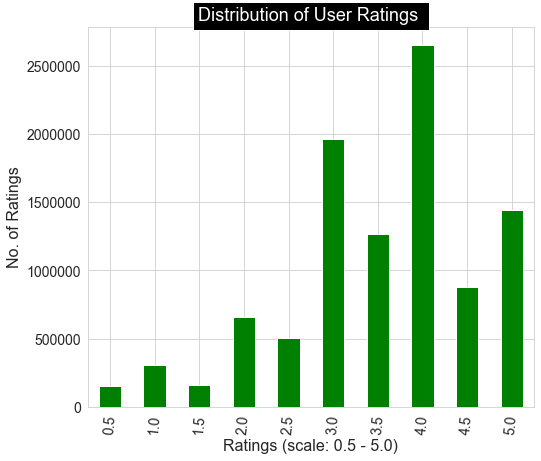

In [12]:
train.groupby('rating')['userId'].count().plot(kind = 'bar', color = 'g',
                                               figsize = (8,7))
plt.xticks(rotation=85, fontsize = 14)
plt.yticks(fontsize = 14)
plt.xlabel('Ratings (scale: 0.5 - 5.0)', fontsize=16)
plt.ylabel('No. of Ratings', fontsize=16)
plt.title('Distribution of User Ratings ',bbox={'facecolor':'k', 'pad':5}
          ,color='w',fontsize = 18)
plt.show

In [13]:
# Calculate and categorise ratings proportions
a = len(train.loc[train['rating']== 0.5]) / len(train)
b = len(train.loc[train['rating']==1.0]) / len(train)
c = len(train.loc[train['rating']==1.5]) / len(train)
d = len(train.loc[train['rating']==2.0]) / len(train)
low_ratings= a+b+c+d
e = len(train.loc[train['rating']==2.5]) / len(train)
f = len(train.loc[train['rating']== 3.0]) / len(train)
g = len(train.loc[train['rating']==3.5]) / len(train)
medium_ratings= e+f+g
h = len(train.loc[train['rating']==4.0]) / len(train)
i = len(train.loc[train['rating']==4.5]) / len(train)
j = len(train.loc[train['rating']==5.0]) / len(train)
high_ratings= h+i+j
# Sanity check for checking if ratings proportions equal 100 percent
low_ratings+medium_ratings+high_ratings==1

True

To view proportions of ratings categories, it is best practice to use pie charts.
Below it can be seen that the 4.0 - 5.0 rating carries the most weight at almost 50%. This is an indication that most people who rate movies, are likely to give a higher rating. 

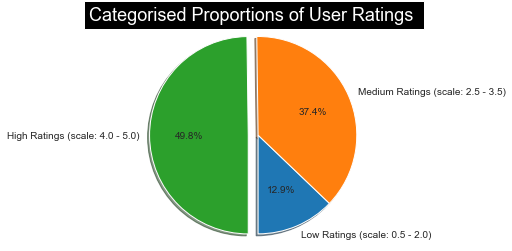

In [20]:
# Creating labels 
labels = 'Low Ratings (scale: 0.5 - 2.0)', 'Medium Ratings (scale: 2.5 - 3.5)', 'High Ratings (scale: 4.0 - 5.0)'
sizes = [low_ratings, medium_ratings,  high_ratings]
explode = (0, 0, 0.1)  # Only "explore" the 3rd slice (i.e. 'Anti')

# Create pie chart with above labels and calculated class proportions as inputs 
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',shadow=True, startangle=270)

# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal') 
plt.title('Categorised Proportions of User Ratings ',bbox={'facecolor':'k',
                                                           'pad':5},color='w'
                                                           ,fontsize = 18)
plt.show()

In [79]:
#ranking top movies based on viewership
def popularity(train,title,ids):
    train_data_grouped = train.groupby([title])[ids].count().reset_index()  #user_id  #movie title
    train_data_grouped.rename(columns = {ids: 'Viewers'},inplace=True)            
    train_data_sort = train_data_grouped.sort_values(['Viewers',title], ascending = [0,1])
    train_data_sort['Rank'] = train_data_sort['Viewers'].rank(ascending=0, method='first')
    popularity_recommendations = train_data_sort.head(10) 
    return popularity_recommendations

In [80]:
train_movies = pd.merge(train,movies, how='left',on='movieId')
top10_movies = popularity(train_movies,'title','userId')
top10_movies

,title,Viewers,Rank
34480,"Shawshank Redemption, The (1994)",32831,1.0
14537,Forrest Gump (1994),32383,2.0
31236,Pulp Fiction (1994),31697,3.0
34840,"Silence of the Lambs, The (1991)",29444,4.0
25144,"Matrix, The (1999)",29014,5.0
36252,Star Wars: Episode IV - A New Hope (1977),27560,6.0
20882,Jurassic Park (1993),25518,7.0
33688,Schindler's List (1993),24004,8.0
6235,Braveheart (1995),23722,9.0
13799,Fight Club (1999),23536,10.0


Text(0.5, 1.0, 'Top 10 Movies by Viewership Numbers ')

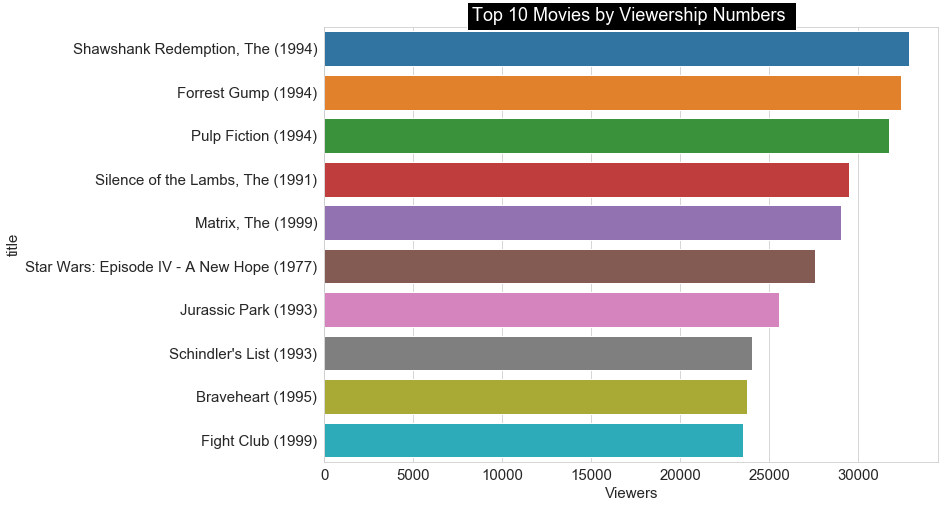

In [122]:
#top 10 movies by number of viewers
plt.figure(figsize = (11,8))
sns.barplot(x='Viewers', y="title", data=top10_movies)
plt.title('Top 10 Movies by Viewership Numbers ',bbox={'facecolor':'k',
                                                           'pad':5},color='w'
                                                           ,fontsize = 18)

In [15]:
# Grouping the data by user
no_of_rated_movies_per_user = train.groupby(by='userId')['rating'].count().sort_values(ascending=False)
no_of_rated_movies_per_user.describe()

count    162541.000000
mean         61.523173
std         107.410889
min           1.000000
25%          14.000000
50%          28.000000
75%          65.000000
max       12952.000000
Name: rating, dtype: float64

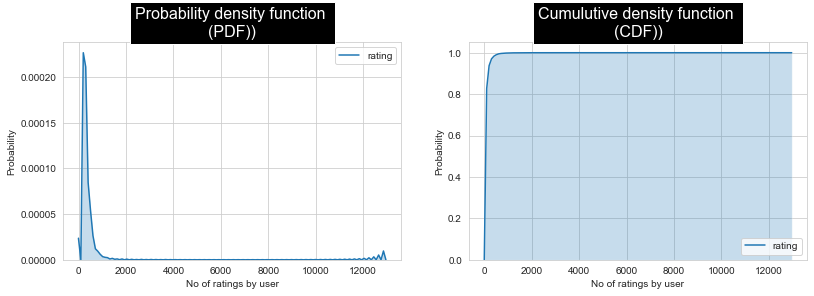

In [16]:
# Plotting the probability density 
fig = plt.figure(figsize=plt.figaspect(.3))

ax1 = plt.subplot(121)
sns.kdeplot(no_of_rated_movies_per_user, shade=True, ax=ax1)
plt.ylabel('Probability')
plt.xlabel('No of ratings by user')
#plt.title("PDF")
plt.title("Probability density function \n(PDF))",bbox={'facecolor':'k',
                                                        'pad':5},color='w'
                                                        ,fontsize = 16)
# Plotting the cumulative probability density
ax2 = plt.subplot(122)
sns.kdeplot(no_of_rated_movies_per_user, shade=True, cumulative=True,ax=ax2)
plt.ylabel('Probability')
plt.xlabel('No of ratings by user')
plt.title("Cumulutive density function \n(CDF))",bbox={'facecolor':'k',
                                                       'pad':5},color='w'
                                                       ,fontsize = 16)

plt.show()

In [17]:
# Storing the quantiles as a variable
quantiles = no_of_rated_movies_per_user.quantile(np.arange(0,1.01,0.01),
                                                 interpolation='higher')

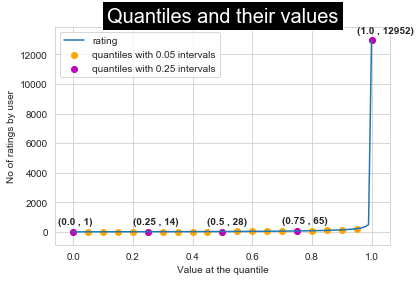

In [18]:
# Plotting the quantiles
plt.title("Quantiles and their values",bbox={'facecolor':'k', 'pad':5},
          color='w',fontsize = 20)
quantiles.plot()
# quantiles with 0.05 difference
plt.scatter(x=quantiles.index[::5], y=quantiles.values[::5], c='orange', 
            label="quantiles with 0.05 intervals")
# quantiles with 0.25 difference
plt.scatter(x=quantiles.index[::25], y=quantiles.values[::25], c='m', 
            label = "quantiles with 0.25 intervals")
plt.ylabel('No of ratings by user')
plt.xlabel('Value at the quantile')
plt.legend(loc='best')

# annotate the 25th, 50th, 75th and 100th percentile values....
for x,y in zip(quantiles.index[::25], quantiles[::25]):
    plt.annotate(s="({} , {})".format(x,y), xy=(x,y), xytext=(x-0.05, y+500)
                ,fontweight='bold')

plt.show()

NameError: name 'result' is not defined

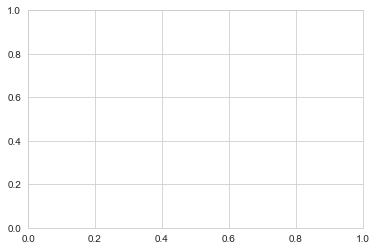

In [21]:
# Plotting the numbers ratings per day
fig, ax = plt.subplots()
sns.countplot(x='day_of_week', data=train, ax=ax, order=result['day_of_week'])
plt.title("No. of ratings on each day",bbox={'facecolor':'k', 'pad':5},color='w',fontsize = 20)
plt.ylabel('Total no of ratings')
plt.xlabel('')
ax.set_yticklabels([human(item, 'M') for item in ax.get_yticks()])
plt.show()

As can be seen, Sunday has the most ratings. This implies that the demand for movies is the highest on Sundays as people will watch a movie and then rate it.

In [ ]:
# Rating scale of each day
fig = plt.figure(figsize=plt.figaspect(.45))
plt.title("Typical rating scale on each day",bbox={'facecolor':'k', 'pad':5},
          color='w',fontsize = 20)
sns.boxplot(y='rating', x='day_of_week', data=train)
plt.show()

In [ ]:
# Average rating per day of week
avg_week_df = train.groupby(by=['day_of_week'])['rating'].mean()
print(" Average ratings")
print("-"*30)
print(avg_week_df)
print("\n")

It can also be noted that movies receive roughly the same average rating irrespective of the day.


The following directors made the most movies in the database

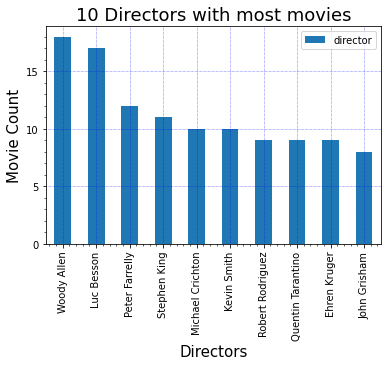

In [ ]:
# Directors with the most movies
most = dftrain['director'].value_counts()[:10].to_frame()
most.plot(kind='bar')
plt.minorticks_on()
plt.grid(which='major', linestyle=':', linewidth='0.5', color='blue')
plt.rcParams.update({'font.size': 15})
plt.title('10 Directors with most movies')
plt.xlabel('Directors',fontsize=15)
plt.ylabel('Movie Count',fontsize=15)
plt.show()

Out of the most content creating directors, it would be prudent to investigate the popularity ratings. This will assist in establishing which director has the strongest following and how the movies they create get rated and will likely be rated by other users.

In [ ]:
# What is the top 10 average rating 
director_list = ['Luc Besson', 'Woody Allen', 'Robert Rodriguez', 'Peter Farrelly', 'Stephen King', 'William Shakespeare', 'Michael Crichton', 'Kevin Smith', 'John Grisham', 'Patrick Melton']
dfdirector= dftrain.groupby('director', as_index=False)['rating'].mean()
top_10 = dfdirector[dfdirector['director'].isin(director_list)]
top_10.set_index('director', inplace= True)

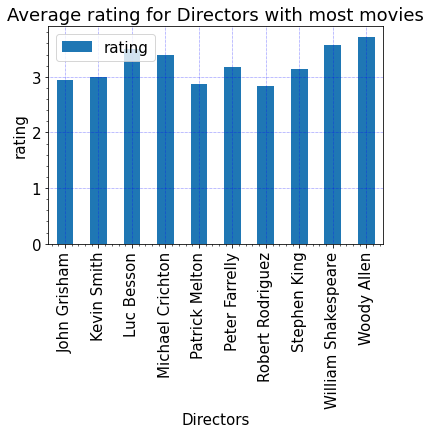

In [ ]:
top_10.plot(kind='bar')
plt.minorticks_on()
plt.grid(which='major', linestyle=':', linewidth='0.5', color='blue')
plt.rcParams.update({'font.size': 15})
plt.title('Average rating for Directors with most movies')
plt.xlabel('Directors',fontsize=15)
plt.ylabel('rating',fontsize=15)
plt.show()

Woody Allen received the highest average rating for a director. This is indicative of his movies being enjoyed by the general masses.

### Word Clouds

Using the imdb_data to extract whether there are favourite actors, directors and even plot keywords. In order to do this, firstly, removing puncuations from the plot keywords and the title cast. Then only can the word clouds be plotted

In [83]:
dfimdb_data = pd.read_csv('imdb_data.csv')

In [84]:
# Setting the text data as string. 
dfimdb_data["title_cast"] = dfimdb_data["title_cast"].astype('str')
dfimdb_data["director"] = dfimdb_data["director"].astype('str')
dfimdb_data["plot_keywords"] = dfimdb_data["plot_keywords"].astype('str')

In [86]:
# Replacing the nan and removing punctuation marks
dfimdb_data["plot_keywords"] = dfimdb_data["plot_keywords"].apply(lambda x:
                                                                  x.replace('|',' '))
dfimdb_data["title_cast"] = dfimdb_data["title_cast"].apply(lambda x:
                                                            x.replace(' ',''))
dfimdb_data["title_cast"] = dfimdb_data["title_cast"].apply(lambda x:
                                                            x.replace('|',' '))
dfimdb_data["director"] = dfimdb_data["director"].apply(lambda x:
                                                        x.replace(' ',''))
dfimdb_data["director"] = dfimdb_data["director"].apply(lambda x:
                                                        x.replace('Seefullsummary',''))
dfimdb_data["director"] = dfimdb_data["director"].apply(lambda x:
                                                        x.replace('nan',''))
dfimdb_data["title_cast"] = dfimdb_data["title_cast"].apply(lambda x:
                                                            x.replace('nan',''))
dfimdb_data["plot_keywords"] = dfimdb_data["plot_keywords"].apply(lambda x:
                                                                  x.replace('nan',''))

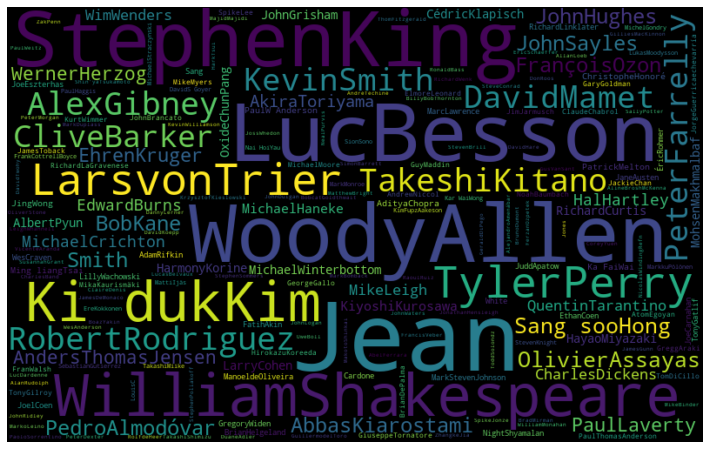

In [87]:
# Storing the director column as a variable
directors = ' '.join([text for text in dfimdb_data["director"]])

# Word cloud for the overall data checking which directors are prominent
wordcloud = WordCloud(width=800, height=500,random_state=21,max_font_size=110).generate(directors)

#ploting the word cloud
plt.figure(figsize=(16,8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

Word clouds by genre

In [93]:
wordcloud = WordCloud(background_color='white', width=800, 
                      height=400).generate(' '.join(dftrain[dftrain['genres']=='Comedy']['plot_keywords']))
plt.figure( figsize=(12,6))
plt.title('Comedy')
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

NameError: name 'dftrain' is not defined

In [90]:
wordcloud = WordCloud(background_color='white', width=800, height=400).generate(' '.join(dftrain[dftrain['genres'] == 'Drama']
                                          ['plot_keywords']))
plt.figure( figsize=(12,6))
plt.title('Drama')
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

NameError: name 'dftrain' is not defined

In [91]:
wordcloud = WordCloud(background_color='white', width=800, height=400).generate(' '.join(dftrain[dftrain['genres'] == 'Action']
                                          ['plot_keywords']))
plt.figure( figsize=(12,6))
plt.title('Action')
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

NameError: name 'dftrain' is not defined

In [ ]:
wordcloud = WordCloud(background_color='white', width=800, height=400).generate(' '.join(dftrain[dftrain['genres'] == 'Thriller']
                                          ['plot_keywords']))
plt.figure( figsize=(12,6))
plt.title('Thriller')
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [ ]:
wordcloud = WordCloud(background_color='white', width=800, height=400).generate(' '.join(dftrain[dftrain['genres'] == 'Romance']
                                          ['plot_keywords']))
plt.figure( figsize=(12,6))
plt.title('Romance')
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [ ]:
wordcloud = WordCloud(background_color='white', width=800, height=400).generate(' '.join(dftrain[dftrain['genres'] == 'Musical']
                                          ['plot_keywords']))
plt.figure( figsize=(12,6))
plt.title('Musical')
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [ ]:
wordcloud = WordCloud(background_color='white', width=800, height=400).generate(' '.join(dftrain[dftrain['genres'] == 'Crime']
                                          ['plot_keywords']))
plt.figure( figsize=(12,6))
plt.title('Crime')
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [ ]:
wordcloud = WordCloud(background_color='white', width=800, height=400).generate(' '.join(dftrain[dftrain['genres'] == 'Adventure']
                                          ['plot_keywords']))
plt.figure( figsize=(12,6))
plt.title('Adventure')
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [ ]:
wordcloud = WordCloud(background_color='white', width=800, height=400).generate(' '.join(dftrain[dftrain['genres'] == 'Animation']
                                          ['plot_keywords']))
plt.figure( figsize=(12,6))
plt.title('Animation')
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [ ]:
wordcloud = WordCloud(background_color='white', width=800, height=400).generate(' '.join(dftrain[dftrain['genres'] == 'Children']
                                          ['plot_keywords']))
plt.figure( figsize=(12,6))
plt.title('Children')
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

# Modelling

## Model evaluation

### Insights

# Conclusion